# Merged PG Analysis - 3 Species (Mtb, Ecoli, Saureus) comparison

### Import Statements

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

#### Pandas Viewing Settings

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
%reload_ext autoreload
%autoreload 2
    
from panqc.utils import parse_PresAbs_Rtab, get_PG_StatsDF_FromPresAbs

from panqc.utils import get_PG_Stats_FromPresAbs, get_PG_Stats_FromPresAbs_V2

from panqc.utils import  parse_PG_Ref_FA


# Define Functions

In [4]:
def parse_PresAbs_Rtab_V2(PresAbs_Rtab_PATH):
    '''
    This function parsesthe `gene_presence_absence.csv` file output by Panaroo '''

    i_Gene_PresAbs_DF = pd.read_csv(PresAbs_Rtab_PATH, sep = "\t")

    ### Relabel Columns for presence/absence tracking
    i_Gene_PresAbs_DF.columns = [ x.split(".CDHIT")[0] for x in i_Gene_PresAbs_DF.columns ]


    ListOf_SampleID_Cols = list(i_Gene_PresAbs_DF.drop(["Gene"], axis=1).columns)
    
    i_Gene_PresAbs_DF["NumAsm_WiGene"] = i_Gene_PresAbs_DF[ListOf_SampleID_Cols].sum(axis = 1)

    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.sort_values(by='NumAsm_WiGene', ascending=False)
    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.set_index("Gene", drop=False)

    return i_Gene_PresAbs_DF

In [5]:
def infer_PG_Stats_FromRtab(i_Pangene_Rtab, i_NumSamples, verbose = False):

    Pangene_Rtab_DF = parse_PresAbs_Rtab_V2(i_Pangene_Rtab)

    NumTotalGenes, NumCoreGenes, NumAccessoryGenes = get_PG_Stats_FromPresAbs(Pangene_Rtab_DF, i_NumSamples)

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    Pangene_PG_Stats_DF = pd.DataFrame(listOf_PG_Rows)
    Pangene_PG_Stats_DF.columns = ["Category", "Range", "GeneCount"]
    
    return Pangene_PG_Stats_DF

In [6]:

def read_PanarooSummaryStats(input_Panaroo_SummaryStats_TXT):
    
    i_Panaroo_Stats_DF = pd.read_csv(input_Panaroo_SummaryStats_TXT, sep = "\t", header=None)
    i_Panaroo_Stats_DF.columns = ["Category", "Range", "GeneCount"]

    Acc_GenesCount = i_Panaroo_Stats_DF["GeneCount"].values[-1] - i_Panaroo_Stats_DF["GeneCount"].values[0]

    i_Panaroo_AccGenesRow = ["Accessory genes","(0% <= strains < 99%)", Acc_GenesCount]

    i_Panaroo_Stats_DF.loc[len(i_Panaroo_Stats_DF.index)] = i_Panaroo_AccGenesRow

    #listOfCat_ToKeep = ["Core genes", "Accessory Genes", "Total genes"]

    i_Panaroo_Stats_DF = i_Panaroo_Stats_DF[ i_Panaroo_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

    # https://www.statology.org/pandas-add-row-to-dataframe/#:~:text=You%20can%20use%20the%20df,loc%5Blen(df. 

    return i_Panaroo_Stats_DF

In [7]:
def read_Ppanggolin_ContextStats(i_Ppanggolin_Default_Content_TXT):
    with open(i_Ppanggolin_Default_Content_TXT, "r") as f:

        #NumCoreGenes = -1
        #NumShellGenes = -1
        #NumCloudGenes = -1
        for line in f:
            line_split = line.split(": ")

            Key = line_split[0].split(" (")[0]
            Value = line_split[-1].strip()

            if Key == "Persistent": NumCoreGenes = int(Value)
            elif Key == "Shell": NumShellGenes = int(Value)
            elif Key == "Cloud": NumCloudGenes = int(Value)

        NumAccessoryGenes = NumShellGenes + NumCloudGenes
        NumTotalGenes = NumCoreGenes + NumAccessoryGenes

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    PPanggolin_Summary_DF = pd.DataFrame(listOf_PG_Rows)
    PPanggolin_Summary_DF.columns = ["Category", "Range", "GeneCount"]
    
    return PPanggolin_Summary_DF

In [8]:

def calculate_gene_gain_loss_stats(branchstats_tsv):
    """
    Calculate gene gain and loss statistics for ancestral branches and tips
    from a branchstats.tsv file generated by Panstripe software.
    
    Parameters:
        branchstats_tsv (str): Path to the branchstats.tsv file.
        
    Returns:
        dict: A dictionary containing the four statistics:
              - N_Gain_AncBranches: Total number of genes gained on ancestral branches.
              - N_Loss_AncBranches: Total number of genes lost on ancestral branches.
              - N_Gain_Tips: Total number of genes gained on tips.
              - N_Loss_Tips: Total number of genes lost on tips.
    """
    # Load the data
    data = pd.read_csv(branchstats_tsv, sep="\t")
    
    # Split the data into ancestral branches and tips
    data_tips = data.query("istip == 1")
    data_ancs = data.query("istip == 0")
    
    # Calculate statistics
    stats = {
        "N_Gain_Ancs": data_ancs["acc_gain"].sum(),
        "N_Loss_Ancs": data_ancs["acc_loss"].sum(),
        "N_Gain_Tips": data_tips["acc_gain"].sum(),
        "N_Loss_Tips": data_tips["acc_loss"].sum()
    }
    
    return stats

# Example usage:
# file_path = "path/to/Panstripe.BranchStats.tsv"
# stats = calculate_gene_gain_loss_stats(file_path)
# print(stats)


In [9]:
def read_BaktaTXT_ToBasicInfoDict(i_BaktaInfo_TXT):
    """
    Function to read in a bakta.txt file. 
    
    The function extracts the following information & stores it as a dictionary:
    1) Total Cumulative Length (Across all contigs), 2) Number of contigs
    3) GC content, 4) Assembly N50, 5) Number CDS, 6) Coding Density
    """
    
    out_BaktaInfo_Dict = {}
    
    i_Asm_BaktaInfo_DF = pd.read_csv(i_BaktaInfo_TXT, sep = ":",header=None)
    i_Asm_BaktaInfo_RawDict = dict(i_Asm_BaktaInfo_DF[[0,1]].values)

    out_BaktaInfo_Dict["TotalContigLength"] = int(i_Asm_BaktaInfo_RawDict["Length"])
    out_BaktaInfo_Dict["NumContigs"] = int(i_Asm_BaktaInfo_RawDict["Count"])
    out_BaktaInfo_Dict["GCcontent"] = float(i_Asm_BaktaInfo_RawDict["GC"] )
    out_BaktaInfo_Dict["N50"] = float(i_Asm_BaktaInfo_RawDict["N50"])
    out_BaktaInfo_Dict["NumCDS"] = int( i_Asm_BaktaInfo_RawDict["CDSs"])

    out_BaktaInfo_Dict["CodingDensity"] = float(i_Asm_BaktaInfo_RawDict["coding density"])
    out_BaktaInfo_Dict["NumHypotheticals"] = int(i_Asm_BaktaInfo_RawDict['hypotheticals'])

    
    return out_BaktaInfo_Dict


# Define paths to metadata & pipeline outputs (All 3 Species)

In [10]:

Proj_MainDir = "/n/data1/hms/dbmi/farhat/mm774/Projects"


### Mtb PG Analysis Files ###

Mtb_WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

WGA151CI_SMK_OutputDir = Mtb_WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"

Mtb_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir
############################################################




### Ecoli PG Analysis Files ###

Ecoli_PG_MainDir = f"{Proj_MainDir}/230905_Ecoli_PG_Analysis"  

Ecoli_SMK_Outputs_Dir = f"{Ecoli_PG_MainDir}/SMK_OutDirs"
PG_Ecoli_50I_OutDir = Ecoli_SMK_Outputs_Dir + "/231011_Ecoli_Shaw2021_5OI_V1"



Ecoli_Data_MainDir = f"{Ecoli_PG_MainDir}/Data"  

Shaw2021_50Asm_Dir = f"{Ecoli_Data_MainDir}/Shaw2021.50Genomes.Data/data"
Shaw2021_Meta_TSV = f"{Ecoli_Data_MainDir}/Shaw2021.SelectedIsolates.50I.tsv"  

Ecoli_Meta_Dir = f"../../Data/230905_Ecoli_50CI_Metadata_Shaw2021"  

Shaw2021_Ecoli_50Asm_Meta_TSV = f"{Ecoli_Meta_Dir}/231011.Shaw2021.Ecoli.50I.MetaData.tsv"



############################################################


### Saureus PG Analysis Files ###

SA_PG_MainDir = f"{Proj_MainDir}/241206_Saureus_PG_Analysis"  

SA_SMK_Outputs_Dir = f"{SA_PG_MainDir}/SMK_OutDirs"

PG_SA_68I_OutDir = SA_SMK_Outputs_Dir + "/241206_Saureus_HoutakBouras2023_68I_V1"



SA_Data_MainDir = f"{SA_PG_MainDir}/Data"  

SA_68CI_GenomeFASTAs_Dir = f"{SA_Data_MainDir}/CRS.Saureus.68CI.GenomesFromGitRepo"

HoutakBouras2023_Saureus_68CI_AsmPATH_AltPath_TSV = f"{SA_PG_MainDir}/241206.HoutakBouras2023.Saureus.68I.MetaData.And.AsmFA.tsv"

Saureus_Repo_Meta_Dir = f"../../Data/241206_Saureus_HoutakBouras2023_Metadata"  

Sa_ENA_RunData_TSV = f"{Saureus_Repo_Meta_Dir}/ENA.RunMetadata.PRJNA914892.tsv"

Sa_HoutakBouras2023_Isolate_Metadata_TSV = f"{Saureus_Repo_Meta_Dir}/HoutakBouras2023.metadata.csv"

Sa_HoutakBouras2023_Isolate_MLST_Info_TSV = f"{Saureus_Repo_Meta_Dir}/metadata/poppunk_mlst.csv"

############################################################




# Parse isolate/sample metadata for all 3 species

## Parse in SA metadata

In [11]:
SA_68CI_Info_DF = pd.read_csv(HoutakBouras2023_Saureus_68CI_AsmPATH_AltPath_TSV,
                               sep = "\t")
print(SA_68CI_Info_DF.shape)

#Sa_68CI_Info_DF = pd.merge(Sa_68CI_Info_DF, MLST_DF, how = "left",
#                           left_on="SampleID", right_on = "SampleID" )

print(SA_68CI_Info_DF.shape)

(68, 8)
(68, 8)


### Define list of SA SampleIDs

In [12]:
SA_68CI_Info_DF.head(1)  

,SampleID,PatientID,Timepoint,Bioproject,SR_RunAccession,Assembly_Accession,Organism,Genome_ASM_PATH
0,C100,276,T0,PRJNA914892,SRR22859841,GCA_030290035.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...


In [13]:
SA68I_SampleIDs = SA_68CI_Info_DF["SampleID"].values   
len(SA68I_SampleIDs)

68

## Parse in Ecoli metadata

In [14]:
Shaw_50A_Info_DF = pd.read_csv(Shaw2021_Ecoli_50Asm_Meta_TSV, sep = "\t")
Shaw_50A_Info_DF.shape

(50, 24)

### Define list of Ecoli SampleIDs

In [15]:
Shaw_50A_Info_DF.head(1)  

,Isolate,Biosample Accession,Short Reads Accession,Long Reads Accession,Assembly Accession,Animal or WwTW,Isolate source information,Timepoint,Niche,Niche.2,Location,Genus,Species,ST assignment,Circularised plasmids,Number of contigs,Circularised chromosome (1=yes),Total genome size (bp),Chromosome GC (if known),Phylogroup (E. coli only),Alternative isolate name,Long read sequencing method,SampleID,Genome_ASM_PATH
0,RH02|T1-C02,SAMN15147960,SRR11948863,SRR12299015,GCA_014109125.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,RH02,Escherichia,Escherichia coli,10.0,1,2,1,4953790,50.7,A,RHB02-C02,PacBio,GCA_014109125,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...


In [16]:
E50I_SampleIDs = Shaw_50A_Info_DF["SampleID"].values   
len(E50I_SampleIDs)

50

## Parse sample Mtb Metadata (N = 151)

In [17]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

# Define paths to all BAKTA Annotations (For both Hybrid & SR ASMs)

In [18]:
SampleTag_ToPaths_Dict = {}

### Mtb 151CI ###
listOfSample_Tags = WGA151CI_SampleIDs
target_SMK_OutputDir = Mtb_SMK_Pipeline_OutputDir

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = f"{target_SMK_OutputDir}/AsmAnalysis/{SampleID}"
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"

    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    Bakta_SR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_SR_Asm_Bakta"

    SampleTag_ToPaths_Dict[SampleID] = {
        "Dataset": "Mtb_151CI",
        "Species": "Mtb",
        "LRAsm_Bakta_GFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3",
        "LRAsm_Bakta_GBFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff",
        "LRAsm_Bakta_FAA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa",
        "LRAsm_Bakta_FFN": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn",
        "LRAsm_Bakta_FNA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna",
        "LRAsm_Bakta_TXT": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt",
        "SRAsm_Bakta_GFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gff3",
        "SRAsm_Bakta_GBFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gbff",
        "SRAsm_Bakta_FAA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.faa",
        "SRAsm_Bakta_FFN": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.ffn",
        "SRAsm_Bakta_FNA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.fna",
        "SRAsm_Bakta_TXT": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.txt",
    }

#########################################################################




##### Ecoli 50CI #####

listOfSample_Tags = E50I_SampleIDs
target_SMK_OutputDir = PG_Ecoli_50I_OutDir

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = f"{target_SMK_OutputDir}/AsmAnalysis/{SampleID}"
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"

    sample_SR_Asm_OutputDir = f"{target_SMK_OutputDir}/SR_DataProcessing/{SampleID}"
    SR_GenomeAnno_Dir = f"{sample_SR_Asm_OutputDir}/GenomeAnnotation"

    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    Bakta_SR_AsmDir = f"{SR_GenomeAnno_Dir}/{SampleID}_Asm_Bakta"

    SampleTag_ToPaths_Dict[SampleID] = {
        "Dataset": "Ecoli_50CI",
        "Species": "Ecoli",
        "LRAsm_Bakta_GFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3",
        "LRAsm_Bakta_GBFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff",
        "LRAsm_Bakta_FAA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa",
        "LRAsm_Bakta_FFN": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn",
        "LRAsm_Bakta_FNA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna",
        "LRAsm_Bakta_TXT": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt",
        "SRAsm_Bakta_GFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gff3",
        "SRAsm_Bakta_GBFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gbff",
        "SRAsm_Bakta_FAA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.faa",
        "SRAsm_Bakta_FFN": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.ffn",
        "SRAsm_Bakta_FNA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.fna",
        "SRAsm_Bakta_TXT": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.txt",
    }

#########################################################################

### Saureus 68CI ###

listOfSample_Tags = SA68I_SampleIDs
target_SMK_OutputDir = PG_SA_68I_OutDir

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = f"{target_SMK_OutputDir}/AsmAnalysis/{SampleID}"
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"

    sample_SR_Asm_OutputDir = f"{target_SMK_OutputDir}/SR_DataProcessing/{SampleID}"
    SR_GenomeAnno_Dir = f"{sample_SR_Asm_OutputDir}/GenomeAnnotation"

    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    Bakta_SR_AsmDir = f"{SR_GenomeAnno_Dir}/{SampleID}_Asm_Bakta"

    SampleTag_ToPaths_Dict[SampleID] = {
        "Dataset": "Saureus_68CI",
        "Species": "Saureus",
        "LRAsm_Bakta_GFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3",
        "LRAsm_Bakta_GBFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff",
        "LRAsm_Bakta_FAA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa",
        "LRAsm_Bakta_FFN": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn",
        "LRAsm_Bakta_FNA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna",
        "LRAsm_Bakta_TXT": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt",
        "SRAsm_Bakta_GFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gff3",
        "SRAsm_Bakta_GBFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gbff",
        "SRAsm_Bakta_FAA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.faa",
        "SRAsm_Bakta_FFN": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.ffn",
        "SRAsm_Bakta_FNA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.fna",
        "SRAsm_Bakta_TXT": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.txt",
    }
    
#########################################################################



In [19]:
#SampleTag_ToPaths_Dict.keys()

# Next

In [86]:
PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Roary_NoSplitParalogs_I80',
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.95.Miniprot0.98'] 

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',
                         'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs', 'Roary_Default',
                         "Ppanggolin_I0.80C0.60",
                         "Ppanggolin_I0.80C0.80",
                         "Ppanggolin_I0.80C0.90",
                         "Ppanggolin_I0.90C0.60",
                         "Ppanggolin_I0.90C0.80",
                         "Ppanggolin_I0.90C0.90",
                         "Ppanggolin_I0.98C0.60",
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.9.Miniprot0.95',
                         'Pangene_0.9.Miniprot0.98',
                         'Pangene_0.9.Miniprot0.99',
                         'Pangene_0.9.Miniprot0.9',
                         'Pangene_0.95.Miniprot0.95',
                         'Pangene_0.95.Miniprot0.98',
                         'Pangene_0.95.Miniprot0.99',
                         'Pangene_0.95.Miniprot0.9',
                         'Pangene_0.98.Miniprot0.95',
                         'Pangene_0.98.Miniprot0.98',
                         'Pangene_0.98.Miniprot0.99',
                         'Pangene_0.98.Miniprot0.9',] 



dictOf_PG_OutInfo = {}
dictOf_PG_PresAbs_DF = {}
dictOf_PG_OutDir_PATHs = {}

target_OutputDir = PG_SA_68I_OutDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

listOfCat_ToKeep = ["Core genes", "Accessory genes", "Total genes"]


dictOf_PG_OutInfo = {}
dictOf_PG_OutFile_PATHs = {}
dictOf_PG_PresAbs_DF = {}
dictOf_PG_PresAbs_WiAsmSeqChk_Dict = {}

for i_SampleSet in ["Mtb", "Ecoli", "Saureus"]:

    dictOf_PG_OutInfo[i_SampleSet] = {}
    dictOf_PG_OutFile_PATHs[i_SampleSet] = {}
    dictOf_PG_PresAbs_DF[i_SampleSet] = {}

    if i_SampleSet == 'Mtb':
        target_OutputDir = Mtb_SMK_Pipeline_OutputDir
        i_NumGenomes = 151
    
    elif i_SampleSet == 'Saureus':
        target_OutputDir = PG_SA_68I_OutDir
        i_NumGenomes = 68
        
    elif i_SampleSet == 'Ecoli':
        target_OutputDir = PG_Ecoli_50I_OutDir
        i_NumGenomes = 50

    
    i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

    
    for AnnoPipeline in ["Bakta"]:
        
        dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_OutFile_PATHs[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline] = {}
        
        for AsmTech in ["LongRead", "ShortRead"]:       
        #for AsmTech in ["LongRead"]:       

            dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_OutFile_PATHs[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech] = {}
            
            
            for i_PipeNameWiParam in tqdm(PipeName_WiParam_List):
                
                dictOf_PG_OutFile_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = {}
                
                if (AsmTech == "ShortRead") & (AnnoPipeline == "PGAP"): continue 
                
                DataSetSuffix = "_AllIsolates"  

                if AsmTech == "LongRead": SeqTechPrefix = ""
                elif AsmTech == "ShortRead": SeqTechPrefix = "SR_"

                if AnnoPipeline == "Bakta": AnnoSuffix = ""


                i_Pipeline_OutDir = f"{i_Pangenome_Dir}/{SeqTechPrefix}{i_PipeNameWiParam}{DataSetSuffix}{AnnoSuffix}"

                i_Pangene_OutDir  = f"{i_Pangenome_Dir}/Pangene/{SeqTechPrefix}{i_PipeNameWiParam}{DataSetSuffix}{AnnoSuffix}"

                if "Pangene" in i_PipeNameWiParam:
                    Pangene_ParamString = i_PipeNameWiParam[8:]
                    # i_PipeNameWiParam
                    print(Pangene_ParamString)

                    if i_SampleSet == "Mtb":
                        i_Gene_PresAbs_Rtab_PATH = f"{i_Pangene_OutDir}/Mtb151CI.{i_PipeNameWiParam}.gene_presence_absence.Rtab"
                        
                    else:
                        i_Gene_PresAbs_Rtab_PATH = f"{i_Pangene_OutDir}/{SeqTechPrefix}{i_PipeNameWiParam}.gene_presence_absence.Rtab"    

                    
                    i_GenePres_DF = parse_PresAbs_Rtab(i_Gene_PresAbs_Rtab_PATH)
                                        
                    i_PG_Stats_DF = get_PG_StatsDF_FromPresAbs(i_GenePres_DF, i_NumGenomes)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    

                
                
                if "Panaroo" in i_PipeNameWiParam:
                    
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"
                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    


                    i_GenePres_DF = parse_PresAbs_Rtab(i_Gene_PresAbs_Rtab_PATH)
                                        
                    i_PG_Stats_DF = get_PG_StatsDF_FromPresAbs(i_GenePres_DF, i_NumGenomes)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"    

                    
                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    
                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    dictOf_PG_OutFile_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutFile_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH


                elif "Roary" in i_PipeNameWiParam:
                    
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"
                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    

                    i_GenePres_DF = parse_PresAbs_Rtab(i_Gene_PresAbs_Rtab_PATH)
                                        
                    i_PG_Stats_DF = get_PG_StatsDF_FromPresAbs(i_GenePres_DF, i_NumGenomes)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet

                    i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"    

                    # GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                    # i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                    # i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                    # i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                    # i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]


                    
                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    
                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"

                    dictOf_PG_OutFile_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutFile_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH

                elif "Ppanggolin" in i_PipeNameWiParam:

                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    

                    i_GenePres_DF = parse_PresAbs_Rtab(i_Gene_PresAbs_Rtab_PATH)
                                        
                    i_PG_Stats_DF = get_PG_StatsDF_FromPresAbs(i_GenePres_DF, i_NumGenomes)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet

                # Panqc results parsing for Panaroo and Roary
                if ("MergeParalogs" in i_PipeNameWiParam) or ("NoSplitParalogs" in i_PipeNameWiParam):
                    
                    i_panqc_outdir = f"{i_Pipeline_OutDir}/panqc_NRC_OutDir/"
                    
                    i_PanQC_AsmSeqCheck_TSV = f"{i_panqc_outdir}/Step1_AsmSeqCheck/AsmSeqCheck.Stats.tsv"
                    i_panqc_AsmSeqCheck_DF = pd.read_csv(i_PanQC_AsmSeqCheck_TSV, sep ="\t")

                    i_PG_Stats_DF["N_CDS_Absent_Total"] = i_panqc_AsmSeqCheck_DF["N_Absent_Total"].values[0]
                    i_PG_Stats_DF["N_CDS_Present"] = i_panqc_AsmSeqCheck_DF["N_Present"].values[0]
                    i_PG_Stats_DF["N_CDSAbsent_DNAAbsent"] = i_panqc_AsmSeqCheck_DF["N_Absent_AbsentInDNA"].values[0]
                    i_PG_Stats_DF["N_CDSAbsent_DNAPresent"] = i_panqc_AsmSeqCheck_DF["N_Absent_PresentInDNA"].values[0]     

                    # Parse Gene presence/absence matrix w/ info regarding presence at the DNA level
                    i_gene_matrix_Wi_AsmSeqCheck_TSV = f"{i_panqc_outdir}/Step1_AsmSeqCheck/gene_presence_absence.AsmSeqCheck.tsv"

                    i_PresAbs_WiAsmSeqCheck_DF = pd.read_csv(i_gene_matrix_Wi_AsmSeqCheck_TSV, sep="\t" ).set_index("Gene", drop=False)

                    i_PresAbs_ASC_AnyAbs_DF = i_PresAbs_WiAsmSeqCheck_DF.query(f"NumAsm_WiGene_DNASeq < {i_NumGenomes} ")
                    i_PresAbs_STD_AnyAbs_DF = i_PresAbs_WiAsmSeqCheck_DF.query(f"NumAsm_WiGene < {i_NumGenomes} ")

                    i_FreqThresh = i_NumGenomes * 0.99
                    
                    i_PresAbs_ASC_Acc_DF = i_PresAbs_WiAsmSeqCheck_DF.query(f"NumAsm_WiGene_DNASeq < {i_FreqThresh} ")
                    i_PresAbs_STD_Acc_DF = i_PresAbs_WiAsmSeqCheck_DF.query(f"NumAsm_WiGene < {i_FreqThresh} ")

                    i_PG_Stats_DF["N_Accessory_STD"] = i_PresAbs_STD_Acc_DF.shape[0]
                    i_PG_Stats_DF["N_Accessory_AsmSeqCheck"] = i_PresAbs_ASC_Acc_DF.shape[0]
                    
                    i_PG_Stats_DF["N_AnyAbs_STD"] = i_PresAbs_STD_Acc_DF.shape[0]
                    i_PG_Stats_DF["N_AnyAbs_AsmSeqCheck"] = i_PresAbs_ASC_AnyAbs_DF.shape[0]

                    
                    #i_PresAbs_WiAsmSeqCheck_DF["NumAsm_WiGene_AdjByIncompCDSAsm_And_CDSAnnoDisc"] = i_PresAbs_WiAsmSeqCheck_DF[i_SampleIDs].applymap(lambda x: 1 if x in [1, 3, 4, 5] else 0).sum(axis = 1)
                    
                    dictOf_PG_PresAbs_WiAsmSeqChk_Dict[i_PipeNameWiParam] = i_PresAbs_WiAsmSeqCheck_DF
                    

                
                # if "Pangene" in i_PipeNameWiParam:
                #     if i_SampleSet == 'Mtb':
                #         i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis/Panstripe.BranchStats.tsv"
                        
                #     if i_SampleSet == 'Saureus':
                #         i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"
            
                #     if i_SampleSet == 'Ecoli':
                #         i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"

                # else:
                    
                #     if i_SampleSet == 'Mtb':
                #         i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"
                        
                #     if i_SampleSet == 'Saureus':
                #         i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"
            
                #     if i_SampleSet == 'Ecoli':
                #         i_Panstripe_BranchStats_TSV_PATH = f"{i_Pipeline_OutDir}/Panstripe_PhyloAnalysis_V2/Panstripe.BranchStats.tsv"


                # GainLoss_Stats = calculate_gene_gain_loss_stats(i_Panstripe_BranchStats_TSV_PATH)
                # i_PG_Stats_DF["N_Gain_Ancs"] = GainLoss_Stats["N_Gain_Ancs"]
                # i_PG_Stats_DF["N_Loss_Ancs"] = GainLoss_Stats["N_Loss_Ancs"]
                # i_PG_Stats_DF["N_Gain_Tips"] = GainLoss_Stats["N_Gain_Tips"]
                # i_PG_Stats_DF["N_Loss_Tips"] = GainLoss_Stats["N_Loss_Tips"]


                
                dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_PG_Stats_DF
                
                dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_GenePres_DF
                
                #dictOf_PG_OutFile_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["panqc_AsmSeqCheck_DF"] = i_panqc_AsmSeqCheck_DF
                
                dictOf_PG_OutFile_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_Rtab"] = i_Gene_PresAbs_Rtab_PATH 

                dictOf_PG_OutFile_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Stats_TXT"] = i_PG_Summary_Txt





 65%|██████▍   | 20/31 [00:03<00:01,  7.56it/s]

0.9.Miniprot0.95
0.9.Miniprot0.98


 71%|███████   | 22/31 [00:03<00:01,  8.10it/s]

0.9.Miniprot0.99
0.9.Miniprot0.9


 77%|███████▋  | 24/31 [00:03<00:00,  8.40it/s]

0.95.Miniprot0.95
0.95.Miniprot0.98


 84%|████████▍ | 26/31 [00:04<00:00,  8.39it/s]

0.95.Miniprot0.99
0.95.Miniprot0.9


 90%|█████████ | 28/31 [00:04<00:00,  8.35it/s]

0.98.Miniprot0.95
0.98.Miniprot0.98


 97%|█████████▋| 30/31 [00:04<00:00,  6.61it/s]

0.98.Miniprot0.99
0.98.Miniprot0.9


 65%|██████▍   | 20/31 [00:03<00:01,  6.31it/s]

0.9.Miniprot0.95
0.9.Miniprot0.98


 71%|███████   | 22/31 [00:03<00:01,  7.20it/s]

0.9.Miniprot0.99
0.9.Miniprot0.9


 77%|███████▋  | 24/31 [00:04<00:00,  7.89it/s]

0.95.Miniprot0.95
0.95.Miniprot0.98


 84%|████████▍ | 26/31 [00:04<00:00,  8.02it/s]

0.95.Miniprot0.99
0.95.Miniprot0.9


 90%|█████████ | 28/31 [00:04<00:00,  8.27it/s]

0.98.Miniprot0.95
0.98.Miniprot0.98


 97%|█████████▋| 30/31 [00:04<00:00,  8.33it/s]

0.98.Miniprot0.99
0.98.Miniprot0.9


 68%|██████▊   | 21/31 [00:03<00:01,  7.96it/s]

0.9.Miniprot0.95
0.9.Miniprot0.98
0.9.Miniprot0.99


 74%|███████▍  | 23/31 [00:03<00:00,  8.82it/s]

0.9.Miniprot0.9
0.95.Miniprot0.95
0.95.Miniprot0.98


 87%|████████▋ | 27/31 [00:03<00:00,  9.99it/s]

0.95.Miniprot0.99
0.95.Miniprot0.9
0.98.Miniprot0.95


 94%|█████████▎| 29/31 [00:03<00:00, 10.29it/s]

0.98.Miniprot0.98
0.98.Miniprot0.99


  0%|          | 0/31 [00:00<?, ?it/s]

0.98.Miniprot0.9


 68%|██████▊   | 21/31 [00:03<00:01,  7.82it/s]

0.9.Miniprot0.95
0.9.Miniprot0.98
0.9.Miniprot0.99


 74%|███████▍  | 23/31 [00:03<00:00,  8.64it/s]

0.9.Miniprot0.9
0.95.Miniprot0.95
0.95.Miniprot0.98


 87%|████████▋ | 27/31 [00:03<00:00,  9.93it/s]

0.95.Miniprot0.99
0.95.Miniprot0.9
0.98.Miniprot0.95


 94%|█████████▎| 29/31 [00:03<00:00, 10.42it/s]

0.98.Miniprot0.98
0.98.Miniprot0.99
0.98.Miniprot0.9


 68%|██████▊   | 21/31 [00:01<00:00, 14.14it/s]

0.9.Miniprot0.95
0.9.Miniprot0.98
0.9.Miniprot0.99
0.9.Miniprot0.9


 81%|████████  | 25/31 [00:01<00:00, 16.39it/s]

0.95.Miniprot0.95
0.95.Miniprot0.98
0.95.Miniprot0.99
0.95.Miniprot0.9


 87%|████████▋ | 27/31 [00:02<00:00, 16.68it/s]

0.98.Miniprot0.95
0.98.Miniprot0.98


  0%|          | 0/31 [00:00<?, ?it/s]

0.98.Miniprot0.99
0.98.Miniprot0.9


 68%|██████▊   | 21/31 [00:01<00:00, 14.67it/s]

0.9.Miniprot0.95
0.9.Miniprot0.98
0.9.Miniprot0.99
0.9.Miniprot0.9


 81%|████████  | 25/31 [00:01<00:00, 15.74it/s]

0.95.Miniprot0.95
0.95.Miniprot0.98
0.95.Miniprot0.99
0.95.Miniprot0.9


 94%|█████████▎| 29/31 [00:02<00:00, 16.45it/s]

0.98.Miniprot0.95
0.98.Miniprot0.98
0.98.Miniprot0.99
0.98.Miniprot0.9


100%|██████████| 31/31 [00:02<00:00, 16.57it/s]


In [21]:
i_PresAbs_WiAsmSeqCheck_DF.head(3)

,Gene,C100,C113,C121,C13,C133,C136,C148,C149,C155,C16,C179,C182,C183,C188,C195,C196,C197,C206,C208,C209,C21,C22,C222,C224,C233,C235,C24,C240,C241,C245,C255,C265,C273,C276,C285,C294,C295,C3,C309,C311,C312,C314,C318,C32,C320,C324,C325,C333,C339,C342,C349,C351,C353,C355,C357,C363,C364,C45,C52,C56,C67,C70,C72,C76,C79,C80,C9,C91,NumAsm_WiGene,NumAsm_WiGene_DNASeq
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sraP,sraP,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,68,68
mngR,mngR,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,68,68
secA2,secA2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,68,68


In [22]:
!ls -1 $i_panqc_outdir

gene_presence_absence.NRCUpdated.tsv
Step1_AsmSeqCheck
Step2_SeqClustering


In [23]:
!ls -1 $i_panqc_outdir/Step1_AsmSeqCheck

AsmSeqCheck.Stats.tsv
gene_presence_absence.AsmSeqCheck.tsv


In [24]:
!ls -1 $i_panqc_outdir/Step2_SeqClustering

AllVsAll.KmerSimilarity.tsv
NSC.ClusterInfo.tsv


### AsmSeqCheck Notes
- 0 means absent (CDS AA seq & DNA seq not found in ASM)
- 1 means CDS AA seq present in SR
- 2 Means abesnt but DNA Seq In Asm ("CDS Annotation Discrepancy")


In [25]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Pangene_0.9.Miniprot0.95_AllIsolates/

gene_presence_absence.Renamed.Rtab
Panstripe_PhyloAnalysis


In [26]:
#!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Panaroo_Sensitive_MergeParalogs_AllIsolates/panqc_NRC_OutDir/Step1_AsmSeqCheck

In [27]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/241206_Saureus_PG_Analysis/SMK_OutDirs/241206_Saureus_HoutakBouras2023_68I_V1/PanGenome_Analysis/Roary_Default_AllIsolates/

accessory_binary_genes.fa
accessory_binary_genes.fa.newick
accessory_graph.dot
accessory.header.embl
accessory.tab
blast_identity_frequency.Rtab
clustered_proteins
core_accessory_graph.dot
core_accessory.header.embl
core_accessory.tab
core_alignment_header.embl
core_gene_alignment.aln
fixed_input_files
gene_presence_absence.csv
gene_presence_absence.Renamed.Rtab
gene_presence_absence.Rtab
number_of_conserved_genes.Rtab
number_of_genes_in_pan_genome.Rtab
number_of_new_genes.Rtab
number_of_unique_genes.Rtab
pan_genome_reference.fa
Panstripe_PhyloAnalysis_V2
summary_statistics.txt


In [28]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Panaroo_Strict_MergeParalogs_AllIsolates/

combined_DNA_CDS.fasta
combined_protein_cdhit_out.txt
combined_protein_cdhit_out.txt.clstr
combined_protein_CDS.fasta
final_graph.gml
gene_data.csv
gene_presence_absence.AdjBy.ASC.NSC.Rtab
gene_presence_absence.AsmGeneSeqChk.tsv
gene_presence_absence.csv
gene_presence_absence.NoBakta.Rtab
gene_presence_absence.PGQC.AdjBy.ASC.NSC.Rtab
gene_presence_absence.PGQC.AdjBy.ASC.NSC.tsv
gene_presence_absence.renamed.Rtab
gene_presence_absence.Renamed.Rtab
gene_presence_absence_roary.csv
gene_presence_absence.Rtab
NSC_08.Clusters.tsv
pan_genome_reference.fa
pan_genome_reference.KmerComparison.AllVsAll.MaxJC.tsv
panqc_NRC_OutDir
Panstripe_AdjByASCandNSC
Panstripe_OG
Panstripe_PhyloAnalysis
Panstripe_PhyloAnalysis_V2
pre_filt_graph.gml
struct_presence_absence.Rtab
summary_statistics.txt


In [29]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Pangene_0.9.Miniprot0.95_AllIsolates/

gene_presence_absence.Renamed.Rtab
Panstripe_PhyloAnalysis


## Peak at individual DFs

In [87]:
dictOf_PG_OutInfo["Mtb"]["Bakta"]["LongRead"].keys()

dict_keys(['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs', 'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict', 'Panaroo_Moderate', 'Panaroo_Sensitive', 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90', 'Roary_NoSplitParalogs', 'Roary_Default', 'Ppanggolin_I0.80C0.60', 'Ppanggolin_I0.80C0.80', 'Ppanggolin_I0.80C0.90', 'Ppanggolin_I0.90C0.60', 'Ppanggolin_I0.90C0.80', 'Ppanggolin_I0.90C0.90', 'Ppanggolin_I0.98C0.60', 'Ppanggolin_I0.98C0.80', 'Ppanggolin_I0.98C0.90', 'Pangene_0.9.Miniprot0.95', 'Pangene_0.9.Miniprot0.98', 'Pangene_0.9.Miniprot0.99', 'Pangene_0.9.Miniprot0.9', 'Pangene_0.95.Miniprot0.95', 'Pangene_0.95.Miniprot0.98', 'Pangene_0.95.Miniprot0.99', 'Pangene_0.95.Miniprot0.9', 'Pangene_0.98.Miniprot0.95', 'Pangene_0.98.Miniprot0.98', 'Pangene_0.98.Miniprot0.99', 'Pangene_0.98.Miniprot0.9'])

In [88]:
dictOf_PG_OutInfo["Mtb"]["Bakta"]["LongRead"]["Ppanggolin_I0.98C0.80"]

,N_Total,N_Core,N_Accessory,Annotation,Method,SeqType,DataSet
0,5888,3578,2310,Bakta,Ppanggolin_I0.98C0.80,LongRead,Mtb


In [32]:
dictOf_PG_OutInfo["Mtb"]["Bakta"]["LongRead"]["Pangene_0.95.Miniprot0.98"]

,N_Total,N_Core,N_Accessory,Annotation,Method,SeqType,DataSet
0,4204,3793,411,Bakta,Pangene_0.95.Miniprot0.98,LongRead,Mtb


In [33]:
dictOf_PG_OutInfo["Mtb"]["Bakta"]["ShortRead"]["Pangene_0.95.Miniprot0.98"]

,N_Total,N_Core,N_Accessory,Annotation,Method,SeqType,DataSet
0,4272,3354,918,Bakta,Pangene_0.95.Miniprot0.98,ShortRead,Mtb


In [34]:
dictOf_PG_OutInfo["Mtb"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]

,N_Total,N_Core,N_Accessory,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent,N_Accessory_STD,N_Accessory_AsmSeqCheck,N_AnyAbs_STD,N_AnyAbs_AsmSeqCheck
0,4200,3779,421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,Mtb,33046,601154,22262,10784,421,335,421,446


In [35]:
dictOf_PG_OutInfo["Mtb"]["Bakta"]["ShortRead"]["Panaroo_Strict_MergeParalogs"]  

,N_Total,N_Core,N_Accessory,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent,N_Accessory_STD,N_Accessory_AsmSeqCheck,N_AnyAbs_STD,N_AnyAbs_AsmSeqCheck
0,4211,3537,674,Bakta,Panaroo_Strict_MergeParalogs,ShortRead,Mtb,35173,600688,19567,15606,674,569,674,1230


In [89]:
Z = dictOf_PG_PresAbs_DF["Mtb"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]
Z.shape

(4200, 153)

In [90]:
i_PG_Ref_FA_PATH = dictOf_PG_OutFile_PATHs["Mtb"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]["Pangenome_Ref_FA"]

i_PG_RefSeqs_Dict = parse_PG_Ref_FA(i_PG_Ref_FA_PATH)

LR_PG_Ref_IDs = list( i_PG_RefSeqs_Dict.keys())

i_PG_Ref_SeqLen_Dict = { key : len(seq) for key, seq in i_PG_RefSeqs_Dict.items() }


In [91]:
Z["Length_bp"] = Z["Gene"].map(i_PG_Ref_SeqLen_Dict)

In [92]:
Z.query("NumAsm_WiGene < 151").head(3)

,Gene,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NumAsm_WiGene,Length_bp
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gmhB,gmhB,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,150,1227
lppH,lppH,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,150,714
group_1163,group_1163,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,150,816


In [93]:
Z.query("NumAsm_WiGene < 151")["Length_bp"].sum()

510334

In [94]:
Z.query("NumAsm_WiGene < 150")["Length_bp"].sum()

400666

In [95]:
Z.query("NumAsm_WiGene < 149")["Length_bp"].sum()

362995

In [96]:
Z.query("NumAsm_WiGene <= 151")["Length_bp"].sum()

4258700

In [44]:
Z.head(5)

,Gene,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NumAsm_WiGene,Length_bp
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
group_2273,group_2273,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,663
group_619,group_619,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,435
moeX,moeX,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,996
eccE3,eccE3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,996
group_618,group_618,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,151,435


In [45]:
i_PG_Ref_SeqLen_Dict["dnaA"]

1491

In [46]:
i_PG_RefSeqs_Dict["dnaA"]

'GTGTGGAACGCGGTCGTCTCCGAACTTAACGGCGACCCTAAGGTTGACGACGGACCCAGCAGTGATGCTAATCTCAGCGCTCCGCTGACCCCTCAGCAAAGGGCTTGGCTCAATCTCGTCCAGCCATTGACCATCGTCGAGGGGTTTGCTCTGTTATCCGTGCCGAGCAGCTTTGTCCAAAACGAAATCGAGCGCCATCTGCGGGCCCCGATTACCGACGCTCTCAGCCGCCGACTCGGACATCAGATCCAACTCGGGGTCCGCATCGCTCCGCCGGCGACCGACGAAGCCGACGACACTACCGTGCCGCCTTCCGAAAATCCTGCTACCACATCGCCAGACACCACAACCGACAACGACGAGATTGATGACAGCGCTGCGGCACGGGGCGATAACCAGCACAGTTGGCCAAGTTACTTCACCGAGCGCCCGCACAATACCGATTCCGCTACCGCTGGCGTAACCAGCCTTAACCGTCGCTACACCTTTGATACGTTCGTTATCGGCGCCTCCAACCGGTTCGCGCACGCCGCCGCCTTGGCGATCGCAGAAGCACCCGCCCGCGCTTACAACCCCCTGTTCATCTGGGGCGAGTCCGGTCTCGGCAAGACACACCTGCTACACGCGGCAGGCAACTATGCCCAACGGTTGTTCCCGGGAATGCGGGTCAAATATGTCTCCACCGAGGAATTCACCAACGACTTCATTAACTCGCTCCGCGATGACCGCAAGGTCGCATTCAAACGCAGCTACCGCGACGTAGACGTGCTGTTGGTCGACGACATCCAATTCATTGAAGGCAAAGAGGGTATTCAAGAGGAGTTCTTCCACACCTTCAACACCTTGCACAATGCCAACAAGCAAATCGTCATCTCATCTGACCGCCCACCCAAGCAGCTCGCCACCCTCGAGGACCGGCTGAGAACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACCACCCGAGCTGGAGACCCGCATCGCCATCTTGCGCAAG

In [47]:
list(i_PG_RefSeqs_Dict.keys())[:10]

['dnaA',
 'dnaN',
 'recF',
 'group_1732',
 'gyrB',
 'gyrA',
 'group_299',
 'group_273',
 'group_249',
 'group_40']

# 1) Merge all Pan-genome counts accross all combinations evaluated

In [63]:

listOf_PG_InfoDFs = []
for i_SampleSet in ["Mtb", "Ecoli", "Saureus"]: 
    for AnnoPipeline in ["Bakta"]:
        for AsmTech in ["LongRead", "ShortRead"]:
            for i_PipeNameWiParam in PipeName_WiParam_List:
                i_PG_Stats_DF = dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]
                
                listOf_PG_InfoDFs.append(i_PG_Stats_DF)


PG_Merged_Stats_LRandSR_DF = pd.concat(listOf_PG_InfoDFs)

PG_Merged_Stats_LRandSR_DF["MethodAndTech"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["MethodAndTechAndAnno"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]  + "_" +PG_Merged_Stats_LRandSR_DF["Annotation"]  

PG_Merged_Stats_LRandSR_DF["AnnoAndTech"] = PG_Merged_Stats_LRandSR_DF["Annotation"] + "-" + PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["PangenomeTool"] = PG_Merged_Stats_LRandSR_DF["Method"].str.split("_").str[0]

PG_Merged_Stats_LRandSR_DF["Acc_ASC_Diff"] = PG_Merged_Stats_LRandSR_DF["N_Accessory_STD"] - PG_Merged_Stats_LRandSR_DF["N_Accessory_AsmSeqCheck"]

PG_Merged_Stats_LRandSR_DF["AnyAbs_ASC_Diff"] = PG_Merged_Stats_LRandSR_DF["N_AnyAbs_STD"] - PG_Merged_Stats_LRandSR_DF["N_AnyAbs_AsmSeqCheck"]

PG_Merged_Stats_LRandSR_DF.shape


(180, 21)

In [64]:
PG_Merged_Stats_LRandSR_DF.head(4)

,N_Total,N_Core,N_Accessory,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent,N_Accessory_STD,N_Accessory_AsmSeqCheck,N_AnyAbs_STD,N_AnyAbs_AsmSeqCheck,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool,Acc_ASC_Diff,AnyAbs_ASC_Diff
0,4200,3779,421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,Mtb,33046.0,601154.0,22262.0,10784.0,421.0,335.0,421.0,446.0,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,86.0,-25.0
0,4280,3825,455,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,Mtb,36487.0,609793.0,23635.0,12852.0,455.0,359.0,455.0,476.0,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,96.0,-21.0
0,4281,3825,456,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,Mtb,36625.0,609806.0,23649.0,12976.0,456.0,360.0,456.0,477.0,Panaroo_Sensitive_MergeParalogs_LongRead,Panaroo_Sensitive_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,96.0,-21.0
0,4305,3787,518,Bakta,Panaroo_Strict,LongRead,Mtb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Panaroo_Strict_LongRead,Panaroo_Strict_LongRead_Bakta,Bakta-LongRead,Panaroo,NaN,NaN


In [65]:
PG_Merged_Stats_LRandSR_DF["Method"].nunique()

30

In [66]:
PG_Merged_Stats_LRandSR_DF["PangenomeTool"].nunique()

4

In [67]:
PG_Merged_Stats_LRandSR_DF["DataSet"].nunique()

3

In [68]:
PG_Merged_Stats_LRandSR_DF.tail()

,N_Total,N_Core,N_Accessory,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent,N_Accessory_STD,N_Accessory_AsmSeqCheck,N_AnyAbs_STD,N_AnyAbs_AsmSeqCheck,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool,Acc_ASC_Diff,AnyAbs_ASC_Diff
0,3996,1779,2217,Bakta,Pangene_0.95.Miniprot0.9,ShortRead,Saureus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pangene_0.95.Miniprot0.9_ShortRead,Pangene_0.95.Miniprot0.9_ShortRead_Bakta,Bakta-ShortRead,Pangene,NaN,NaN
0,4039,1775,2264,Bakta,Pangene_0.98.Miniprot0.95,ShortRead,Saureus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pangene_0.98.Miniprot0.95_ShortRead,Pangene_0.98.Miniprot0.95_ShortRead_Bakta,Bakta-ShortRead,Pangene,NaN,NaN
0,4042,1776,2266,Bakta,Pangene_0.98.Miniprot0.98,ShortRead,Saureus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pangene_0.98.Miniprot0.98_ShortRead,Pangene_0.98.Miniprot0.98_ShortRead_Bakta,Bakta-ShortRead,Pangene,NaN,NaN
0,4038,1775,2263,Bakta,Pangene_0.98.Miniprot0.99,ShortRead,Saureus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pangene_0.98.Miniprot0.99_ShortRead,Pangene_0.98.Miniprot0.99_ShortRead_Bakta,Bakta-ShortRead,Pangene,NaN,NaN
0,4019,1776,2243,Bakta,Pangene_0.98.Miniprot0.9,ShortRead,Saureus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pangene_0.98.Miniprot0.9_ShortRead,Pangene_0.98.Miniprot0.9_ShortRead_Bakta,Bakta-ShortRead,Pangene,NaN,NaN


In [70]:
PG_Merged_Stats_LRandSR_DF.query("Method == 'Roary_NoSplitParalogs_I90' & Annotation == 'Bakta'")

,N_Total,N_Core,N_Accessory,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent,N_Accessory_STD,N_Accessory_AsmSeqCheck,N_AnyAbs_STD,N_AnyAbs_AsmSeqCheck,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool,Acc_ASC_Diff,AnyAbs_ASC_Diff
0,4293,3723,570,Bakta,Roary_NoSplitParalogs_I90,LongRead,Mtb,54830.0,593413.0,25538.0,29292.0,570.0,382.0,570.0,519.0,Roary_NoSplitParalogs_I90_LongRead,Roary_NoSplitParalogs_I90_LongRead_Bakta,Bakta-LongRead,Roary,188.0,51.0
0,4956,3326,1630,Bakta,Roary_NoSplitParalogs_I90,ShortRead,Mtb,151288.0,597068.0,57420.0,93868.0,1630.0,1063.0,1630.0,1868.0,Roary_NoSplitParalogs_I90_ShortRead,Roary_NoSplitParalogs_I90_ShortRead_Bakta,Bakta-ShortRead,Roary,567.0,-238.0
0,14851,2915,11936,Bakta,Roary_NoSplitParalogs_I90,LongRead,Ecoli,506502.0,236048.0,504937.0,1565.0,11936.0,11932.0,11936.0,11932.0,Roary_NoSplitParalogs_I90_LongRead,Roary_NoSplitParalogs_I90_LongRead_Bakta,Bakta-LongRead,Roary,4.0,4.0
0,14933,2711,12222,Bakta,Roary_NoSplitParalogs_I90,ShortRead,Ecoli,511437.0,235213.0,508532.0,2905.0,12222.0,12204.0,12222.0,12204.0,Roary_NoSplitParalogs_I90_ShortRead,Roary_NoSplitParalogs_I90_ShortRead_Bakta,Bakta-ShortRead,Roary,18.0,18.0
0,4358,2092,2266,Bakta,Roary_NoSplitParalogs_I90,LongRead,Saureus,123845.0,172499.0,122982.0,863.0,2266.0,2261.0,2266.0,2261.0,Roary_NoSplitParalogs_I90_LongRead,Roary_NoSplitParalogs_I90_LongRead_Bakta,Bakta-LongRead,Roary,5.0,5.0
0,4353,1715,2638,Bakta,Roary_NoSplitParalogs_I90,ShortRead,Saureus,124807.0,171197.0,124030.0,777.0,2638.0,2615.0,2638.0,2615.0,Roary_NoSplitParalogs_I90_ShortRead,Roary_NoSplitParalogs_I90_ShortRead_Bakta,Bakta-ShortRead,Roary,23.0,23.0


In [71]:
PG_Merged_Stats_LRandSR_DF.query("Method == 'Panaroo_Strict_MergeParalogs' & Annotation == 'Bakta'")

,N_Total,N_Core,N_Accessory,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent,N_Accessory_STD,N_Accessory_AsmSeqCheck,N_AnyAbs_STD,N_AnyAbs_AsmSeqCheck,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool,Acc_ASC_Diff,AnyAbs_ASC_Diff
0,4200,3779,421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,Mtb,33046.0,601154.0,22262.0,10784.0,421.0,335.0,421.0,446.0,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,86.0,-25.0
0,4211,3537,674,Bakta,Panaroo_Strict_MergeParalogs,ShortRead,Mtb,35173.0,600688.0,19567.0,15606.0,674.0,569.0,674.0,1230.0,Panaroo_Strict_MergeParalogs_ShortRead,Panaroo_Strict_MergeParalogs_ShortRead_Bakta,Bakta-ShortRead,Panaroo,105.0,-556.0
0,14410,3035,11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,Ecoli,481903.0,238597.0,475996.0,5907.0,11375.0,11369.0,11375.0,11369.0,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,6.0,6.0
0,12836,2834,10002,Bakta,Panaroo_Strict_MergeParalogs,ShortRead,Ecoli,406594.0,235206.0,402062.0,4532.0,10002.0,9995.0,10002.0,9995.0,Panaroo_Strict_MergeParalogs_ShortRead,Panaroo_Strict_MergeParalogs_ShortRead_Bakta,Bakta-ShortRead,Panaroo,7.0,7.0
0,4100,2144,1956,Bakta,Panaroo_Strict_MergeParalogs,LongRead,Saureus,105466.0,173334.0,103061.0,2405.0,1956.0,1948.0,1956.0,1948.0,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,8.0,8.0
0,3791,1780,2011,Bakta,Panaroo_Strict_MergeParalogs,ShortRead,Saureus,86031.0,171757.0,84304.0,1727.0,2011.0,2000.0,2011.0,2000.0,Panaroo_Strict_MergeParalogs_ShortRead,Panaroo_Strict_MergeParalogs_ShortRead_Bakta,Bakta-ShortRead,Panaroo,11.0,11.0


# Analysis of CDS Annotation Discrepancy for all 3 species

In [117]:
listOf_ToolParams_ToKeep = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                            'Panaroo_Sensitive_MergeParalogs', 'Roary_NoSplitParalogs_I80',
                            'Roary_NoSplitParalogs_I90', 'Roary_NoSplitParalogs']


TarCols_CDSDisc_Info = ["DataSet", "SeqType", "Annotation", "Method",
                        "N_CDS_Absent_Total", "N_CDSAbsent_DNAPresent", 
                        "N_Accessory_STD", "N_Accessory_AsmSeqCheck", "Acc_ASC_Diff"]

CDS_Disc_Info_DF = PG_Merged_Stats_LRandSR_DF[TarCols_CDSDisc_Info]

CDS_Disc_Info_DF["CDSAnnoDisc_Percent"] = (CDS_Disc_Info_DF["N_CDSAbsent_DNAPresent"] / CDS_Disc_Info_DF["N_CDS_Absent_Total"]) * 100

CDS_Disc_Info_DF = CDS_Disc_Info_DF[CDS_Disc_Info_DF["Method"].isin(listOf_ToolParams_ToKeep)]

# Adding a new column to split results within Mtb between Panaroo and Roary
CDS_Disc_Info_DF['Tool'] = CDS_Disc_Info_DF['Method'].apply(
    lambda x: 'Panaroo' if 'Panaroo' in x else 'Roary' if 'Roary' in x else 'Other'
)

CDS_Disc_Info_DF.shape

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


(36, 11)

In [113]:
CDS_Disc_Info_DF.to_csv("CDS_Disc_Info_DF.csv", index=False)

In [114]:
CDS_Disc_Mtb_DF = CDS_Disc_Info_DF.query("DataSet == 'Mtb'")
CDS_Disc_Ecoli_DF = CDS_Disc_Info_DF.query("DataSet == 'Ecoli'")
CDS_Disc_Saureus_DF = CDS_Disc_Info_DF.query("DataSet == 'Saureus'")

In [115]:
CDS_Disc_Mtb_DF

,DataSet,SeqType,Annotation,Method,N_CDS_Absent_Total,N_CDSAbsent_DNAPresent,N_Accessory_STD,N_Accessory_AsmSeqCheck,Acc_ASC_Diff,CDSAnnoDisc_Percent
0,Mtb,LongRead,Bakta,Panaroo_Strict_MergeParalogs,33046.0,10784.0,421.0,335.0,86.0,32.633299
0,Mtb,LongRead,Bakta,Panaroo_Moderate_MergeParalogs,36487.0,12852.0,455.0,359.0,96.0,35.223504
0,Mtb,LongRead,Bakta,Panaroo_Sensitive_MergeParalogs,36625.0,12976.0,456.0,360.0,96.0,35.429352
0,Mtb,LongRead,Bakta,Roary_NoSplitParalogs_I80,51372.0,28144.0,538.0,360.0,178.0,54.784708
0,Mtb,LongRead,Bakta,Roary_NoSplitParalogs_I90,54830.0,29292.0,570.0,382.0,188.0,53.423308
0,Mtb,LongRead,Bakta,Roary_NoSplitParalogs,64856.0,35226.0,650.0,423.0,227.0,54.314173
0,Mtb,ShortRead,Bakta,Panaroo_Strict_MergeParalogs,35173.0,15606.0,674.0,569.0,105.0,44.369261
0,Mtb,ShortRead,Bakta,Panaroo_Moderate_MergeParalogs,51869.0,24976.0,808.0,670.0,138.0,48.152075
0,Mtb,ShortRead,Bakta,Panaroo_Sensitive_MergeParalogs,83674.0,40190.0,1024.0,834.0,190.0,48.031647
0,Mtb,ShortRead,Bakta,Roary_NoSplitParalogs_I80,141774.0,89760.0,1542.0,992.0,550.0,63.312032


In [106]:
CDS_Disc_Ecoli_DF

,DataSet,SeqType,Annotation,Method,N_CDS_Absent_Total,N_CDSAbsent_DNAPresent,N_Accessory_STD,N_Accessory_AsmSeqCheck,Acc_ASC_Diff,CDSAnnoDisc_Percent
0,Ecoli,LongRead,Bakta,Panaroo_Strict_MergeParalogs,481903.0,5907.0,11375.0,11369.0,6.0,1.225765
0,Ecoli,LongRead,Bakta,Panaroo_Moderate_MergeParalogs,492058.0,6042.0,11605.0,11599.0,6.0,1.227904
0,Ecoli,LongRead,Bakta,Panaroo_Sensitive_MergeParalogs,511208.0,6790.0,11996.0,11990.0,6.0,1.328226
0,Ecoli,LongRead,Bakta,Roary_NoSplitParalogs_I80,431078.0,1218.0,10277.0,10273.0,4.0,0.282547
0,Ecoli,LongRead,Bakta,Roary_NoSplitParalogs_I90,506502.0,1565.0,11936.0,11932.0,4.0,0.308982
0,Ecoli,LongRead,Bakta,Roary_NoSplitParalogs,651347.0,9108.0,15299.0,15281.0,18.0,1.398333
0,Ecoli,ShortRead,Bakta,Panaroo_Strict_MergeParalogs,406594.0,4532.0,10002.0,9995.0,7.0,1.114625
0,Ecoli,ShortRead,Bakta,Panaroo_Moderate_MergeParalogs,435712.0,5878.0,10628.0,10620.0,8.0,1.349056
0,Ecoli,ShortRead,Bakta,Panaroo_Sensitive_MergeParalogs,536646.0,10528.0,12690.0,12682.0,8.0,1.961815
0,Ecoli,ShortRead,Bakta,Roary_NoSplitParalogs_I80,437116.0,2419.0,10595.0,10577.0,18.0,0.553400


In [107]:
CDS_Disc_Saureus_DF

,DataSet,SeqType,Annotation,Method,N_CDS_Absent_Total,N_CDSAbsent_DNAPresent,N_Accessory_STD,N_Accessory_AsmSeqCheck,Acc_ASC_Diff,CDSAnnoDisc_Percent
0,Saureus,LongRead,Bakta,Panaroo_Strict_MergeParalogs,105466.0,2405.0,1956.0,1948.0,8.0,2.280356
0,Saureus,LongRead,Bakta,Panaroo_Moderate_MergeParalogs,107110.0,2458.0,1990.0,1982.0,8.0,2.294837
0,Saureus,LongRead,Bakta,Panaroo_Sensitive_MergeParalogs,114480.0,2628.0,2100.0,2092.0,8.0,2.295597
0,Saureus,LongRead,Bakta,Roary_NoSplitParalogs_I80,101654.0,566.0,1875.0,1871.0,4.0,0.556791
0,Saureus,LongRead,Bakta,Roary_NoSplitParalogs_I90,123845.0,863.0,2266.0,2261.0,5.0,0.696839
0,Saureus,LongRead,Bakta,Roary_NoSplitParalogs,168980.0,6600.0,3024.0,2987.0,37.0,3.905788
0,Saureus,ShortRead,Bakta,Panaroo_Strict_MergeParalogs,86031.0,1727.0,2011.0,2000.0,11.0,2.007416
0,Saureus,ShortRead,Bakta,Panaroo_Moderate_MergeParalogs,90964.0,2152.0,2094.0,2083.0,11.0,2.365771
0,Saureus,ShortRead,Bakta,Panaroo_Sensitive_MergeParalogs,119413.0,3238.0,2519.0,2508.0,11.0,2.711598
0,Saureus,ShortRead,Bakta,Roary_NoSplitParalogs_I80,103772.0,487.0,2281.0,2257.0,24.0,0.469298


### Plot CDS Disc Info

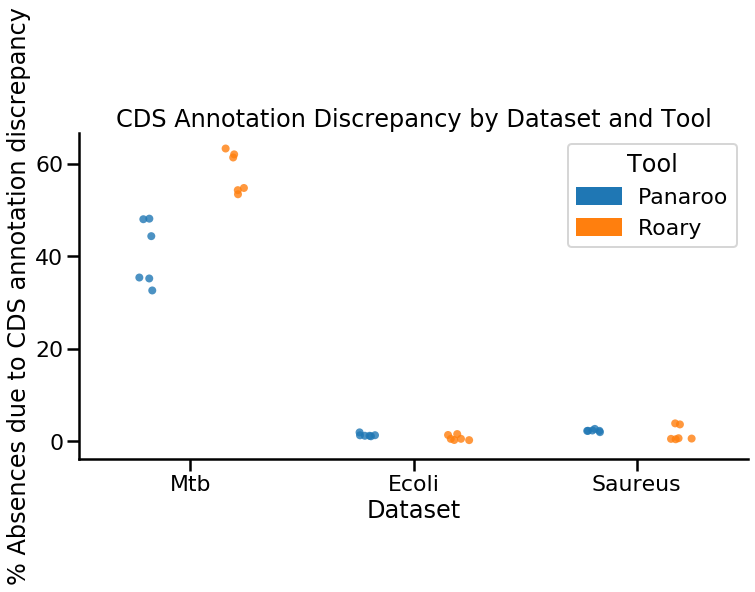

In [120]:
import matplotlib.patches as mpatches

# Define colors for tools
tool_colors = {
    "Panaroo": "#1f77b4",  # Blue
    "Roary": "#ff7f0e"     # Orange
}

# Update the stripplot with specific colors for tools
plt.figure(figsize=(12, 6))
sns.stripplot(
    x="DataSet", 
    y="CDSAnnoDisc_Percent", 
    hue="Tool", 
    data=CDS_Disc_Info_DF, 
    jitter=True, 
    dodge=True, 
    alpha=0.8, 
    linewidth=0, 
    size=8, 
    marker="o", 
    edgecolor='gray', 
    palette=tool_colors
)
plt.title('CDS Annotation Discrepancy by Dataset and Tool')
plt.ylabel('% Absences due to CDS annotation discrepancy')
plt.xlabel('Dataset')

# Add legend with custom colors
legend_patches = [
    mpatches.Patch(color=color, label=tool) for tool, color in tool_colors.items()
]
plt.legend(handles=legend_patches, title="Tool", loc='upper right')
sns.despine()
plt.show()

# Viz Explore - V2

In [76]:
import matplotlib.patches as mpatches


In [77]:
Tools_hue_Color_Dict = {"Panaroo": "#1f77b4",
                        "Roary": "#ff7f0e",
                        "Ppanggolin": "#2ca02c" ,
                        "Pangene": "red" }

Panaroo_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Panaroo"], label='Panaroo')
Roary_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Roary"], label='Roary')
Ppanggolin_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Ppanggolin"], label='Ppanggolin')
Pangene_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Pangene"], label='Pangene')

ToolPatches_List = [Panaroo_patch, Roary_patch, Ppanggolin_patch, Pangene_patch]



hue_Order_Tools = ["Panaroo", "Roary", "Ppanggolin", "Pangene"]
Order_AnnoAndType = ['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead']


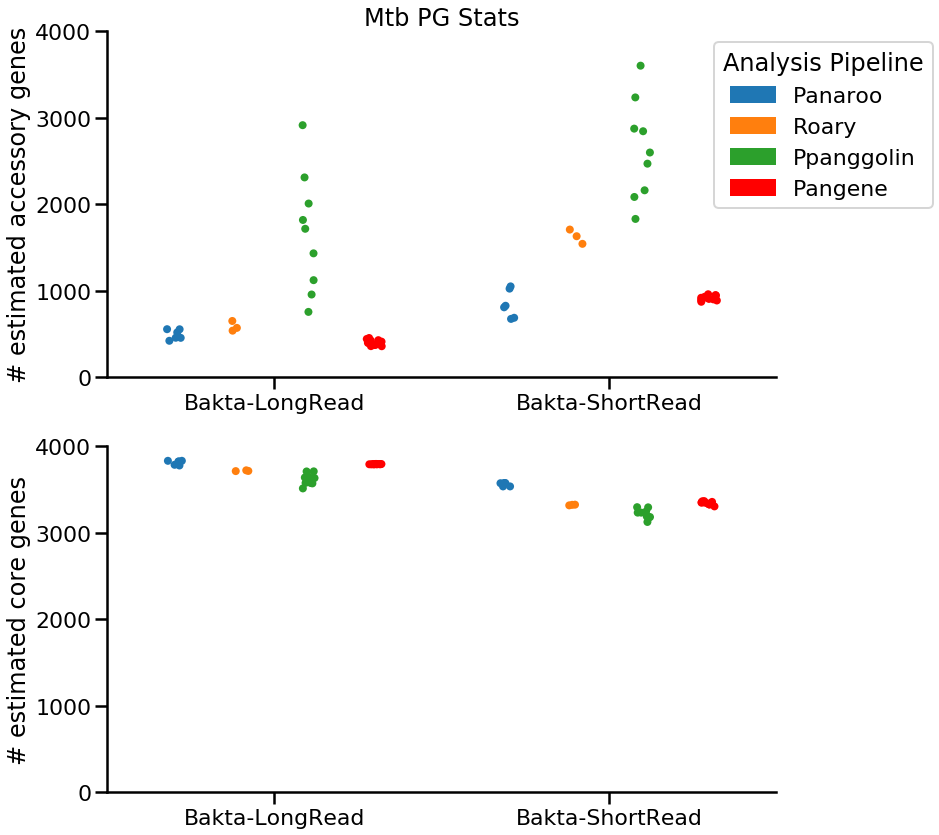

In [80]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (12, 14), sharey = False)

in_PG_Stats_DF = PG_Merged_Stats_LRandSR_DF.query("DataSet == 'Mtb' ")

sns.stripplot(y = "N_Accessory", x = "AnnoAndTech", hue = "PangenomeTool",
              data = in_PG_Stats_DF, linewidth=0, size = 8,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])


sns.stripplot(y = "N_Core", x = "AnnoAndTech", hue = "PangenomeTool",
              data = in_PG_Stats_DF, linewidth=0, size = 8,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

axs[0].set_title("Mtb PG Stats")

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

axs[0].set_ylim(0, 4000)
axs[1].set_ylim(0, 4000)

sns.despine()

plt.show()

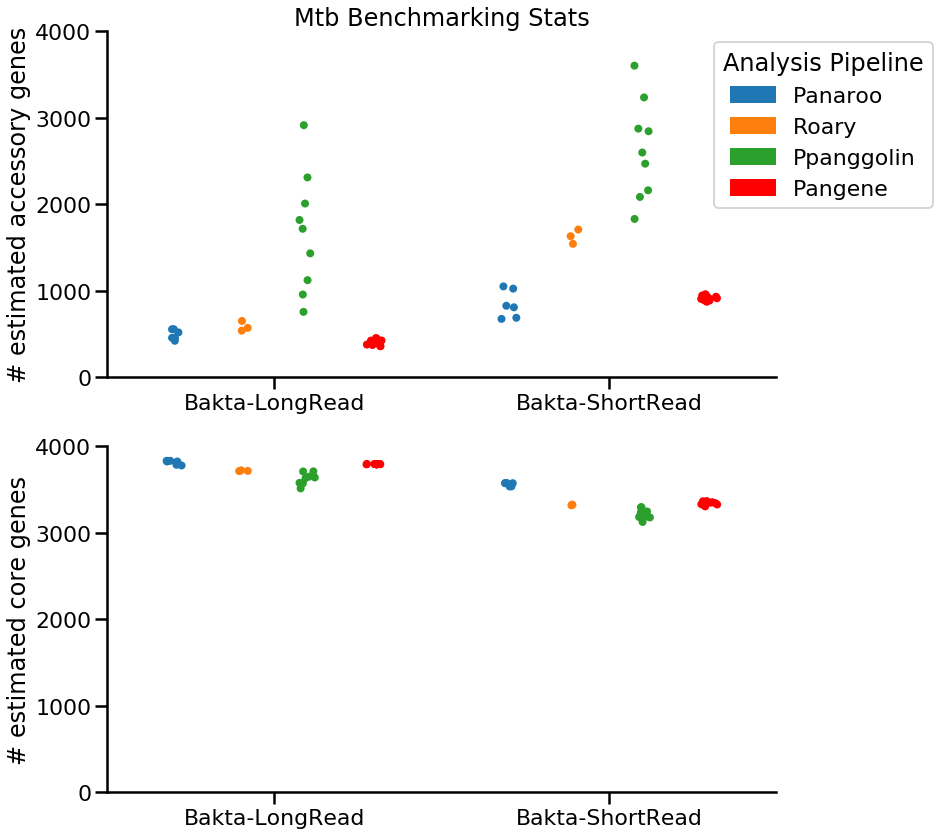

In [81]:

sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (12, 14), sharey = False)

i_Dataset = "Mtb"

in_PG_Stats_DF = PG_Merged_Stats_LRandSR_DF.query(f"DataSet == '{i_Dataset}' ")

sns.stripplot(y = "N_Accessory", x = "AnnoAndTech", hue = "PangenomeTool",
              data = in_PG_Stats_DF, linewidth=0, size = 8,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])


sns.stripplot(y = "N_Core", x = "AnnoAndTech", hue = "PangenomeTool",
              data = in_PG_Stats_DF, linewidth=0, size = 8,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

axs[0].set_title(f"{i_Dataset} Benchmarking Stats")

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

axs[0].set_ylim(0, 4000)
axs[1].set_ylim(0, 4000)

sns.despine()

plt.show()

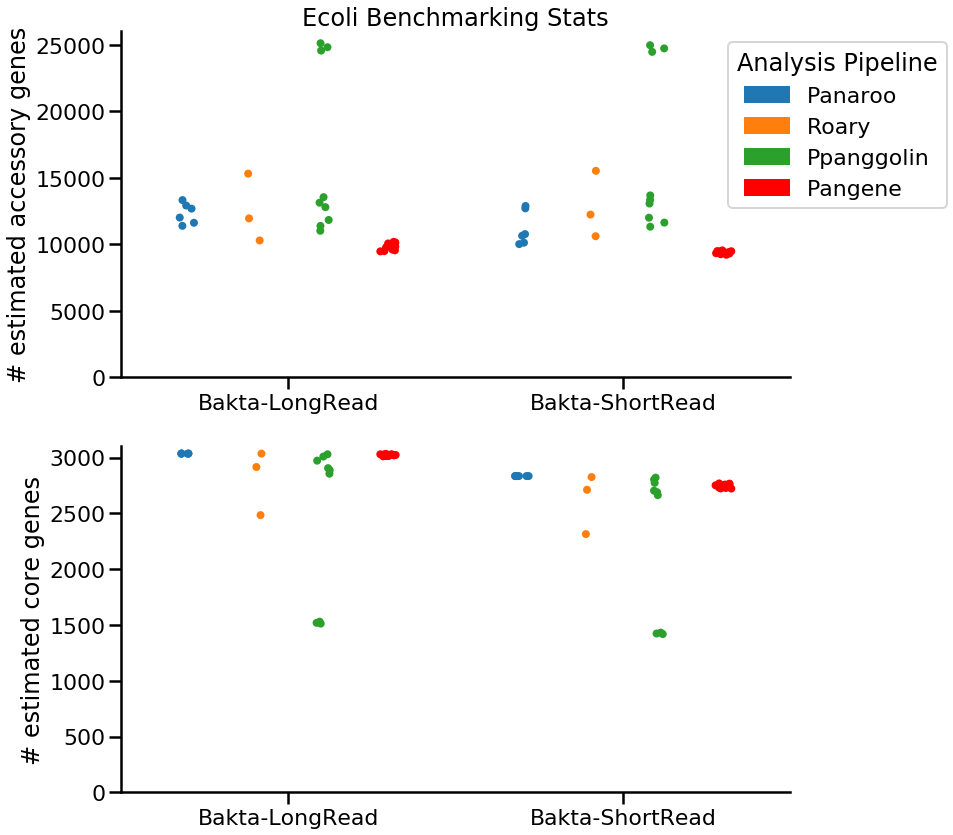

In [82]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (12, 14), sharey = False)

i_Dataset = "Ecoli"

in_PG_Stats_DF = PG_Merged_Stats_LRandSR_DF.query(f"DataSet == '{i_Dataset}' ")

sns.stripplot(y = "N_Accessory", x = "AnnoAndTech", hue = "PangenomeTool",
              data = in_PG_Stats_DF, linewidth=0, size = 8,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])


sns.stripplot(y = "N_Core", x = "AnnoAndTech", hue = "PangenomeTool",
              data = in_PG_Stats_DF, linewidth=0, size = 8,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

axs[0].set_title(f"{i_Dataset} Benchmarking Stats")

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()
axs[0].set_ylim(0, 26000)
axs[1].set_ylim(0, 3100)

sns.despine()

plt.show()

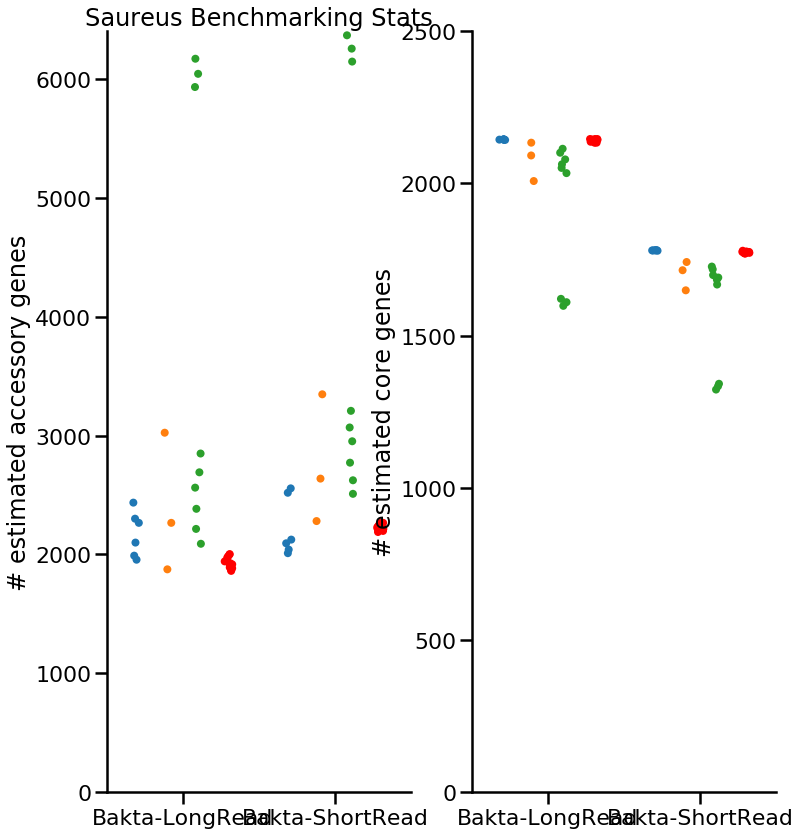

In [162]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(1, 2, figsize= (12, 14), sharey = False)

i_Dataset = "Saureus"

in_PG_Stats_DF = PG_Merged_Stats_LRandSR_DF.query(f"DataSet == '{i_Dataset}' ")

sns.stripplot(y = "N_Accessory", x = "AnnoAndTech", hue = "PangenomeTool",
              data = in_PG_Stats_DF, linewidth=0, size = 8,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])


sns.stripplot(y = "N_Core", x = "AnnoAndTech", hue = "PangenomeTool",
              data = in_PG_Stats_DF, linewidth=0, size = 8,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

axs[0].set_title(f"{i_Dataset} Benchmarking Stats")

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

axs[0].set_ylim(0, 6400)
axs[1].set_ylim(0, 2500)

sns.despine()

plt.show()

mkdir: cannot create directory ‘./Results4_Plots_Rev1/’: File exists


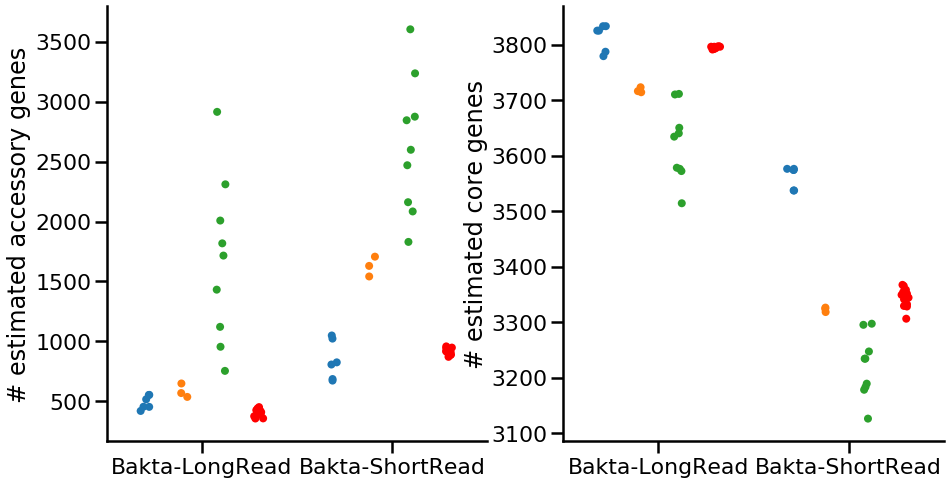

mkdir: cannot create directory ‘./Results4_Plots_Rev1/’: File exists


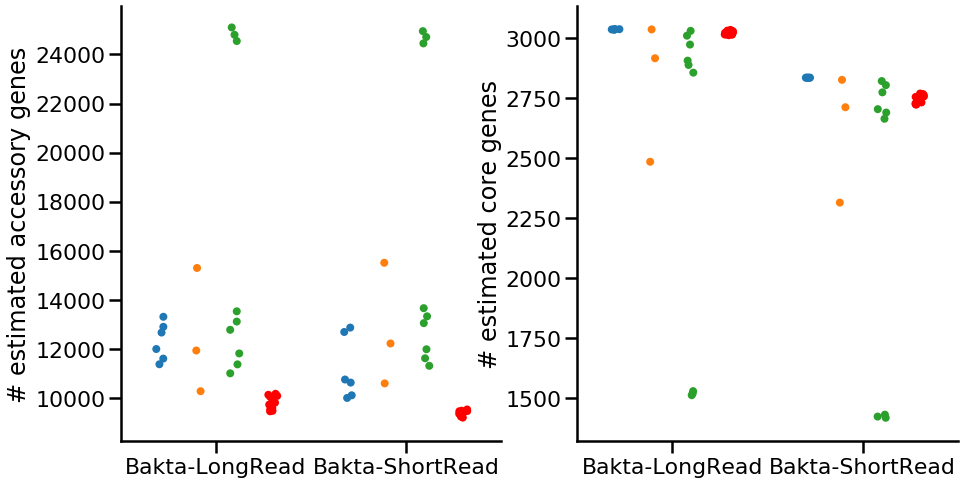

mkdir: cannot create directory ‘./Results4_Plots_Rev1/’: File exists


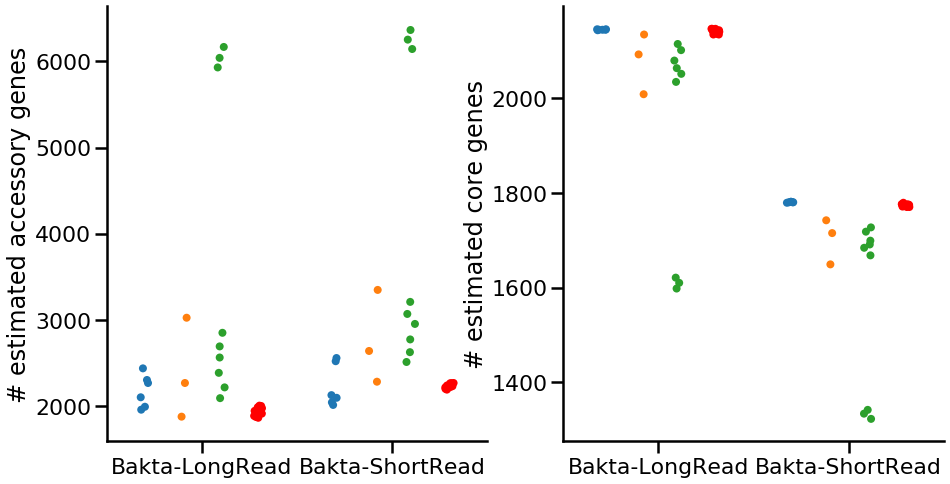

In [163]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")




for i_Dataset in ["Mtb", "Ecoli", "Saureus"]:
    # Create a subplot
    fig, axs = plt.subplots(1, 2, figsize= (15, 8), sharey = False)
    
    in_PG_Stats_DF = PG_Merged_Stats_LRandSR_DF.query(f"DataSet == '{i_Dataset}' ")
    
    sns.stripplot(y = "N_Accessory", x = "AnnoAndTech", hue = "PangenomeTool",
                  data = in_PG_Stats_DF, linewidth=0, size = 8,
                  palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
                  alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])
    
    
    sns.stripplot(y = "N_Core", x = "AnnoAndTech", hue = "PangenomeTool",
                  data = in_PG_Stats_DF, linewidth=0, size = 8,
                  palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
                  alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])
    
    #axs[0].set_title(f"{i_Dataset} Benchmarking Stats")
    
    axs[0].set_xlabel(""), axs[1].set_xlabel("")
    axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 
    
    axs[0].legend(title = "Analysis Pipeline",
                  handles=ToolPatches_List,
                  bbox_to_anchor=(1.25, 1))
    axs[0].get_legend().remove()
    axs[1].get_legend().remove()

    !mkdir ./Results4_Plots_Rev1/
    plt.savefig(f"Results4_Plots_Rev1/3.PG.Counts.SRvsLR.Bakta.CombinedCoreAccPlots.{i_Dataset}.png", dpi = 300, bbox_inches="tight")
    plt.savefig(f"Results4_Plots_Rev1/3.PG.Counts.SRvsLR.Bakta.CombinedCoreAccPlots.{i_Dataset}.svg", bbox_inches="tight")

    sns.despine()
    
    plt.show()

In [129]:
PG_Merged_Stats_LRandSR_DF.groupby("DataSet")["N_Core"].describe()  

,count,mean,std,min,25%,50%,75%,max
DataSet,,,,,,,,
Ecoli,60.0,2727.800000,448.142146,1418.0,2730.00,2834.0,3019.50,3036.0
Mtb,60.0,3543.350000,224.516567,3126.0,3331.25,3575.0,3791.25,3833.0
Saureus,60.0,1888.683333,232.870044,1323.0,1763.00,1780.0,2135.50,2146.0


In [128]:
PG_Merged_Stats_LRandSR_DF.groupby("DataSet")["N_Accessory"].describe()  

,count,mean,std,min,25%,50%,75%,max
DataSet,,,,,,,,
Ecoli,60.0,12400.633333,4443.350679,9201.0,9582.25,10879.5,12877.00,25101.0
Mtb,60.0,1153.650000,833.074108,358.0,502.50,902.5,1649.25,3602.0
Saureus,60.0,2676.733333,1218.793233,1862.0,2009.00,2243.5,2627.50,6366.0


In [ ]:
# E.coli Core: 1418 - 3036
# E.coli Acc: 9201 - 25101

# S.aur Core: 1323 - 2146
# S.aur Acc: 1862 - 6366


In [153]:
PG_Merged_Stats_LRandSR_DF.groupby(["DataSet", "SeqType"])["N_Total"].describe()[["mean", "min", "max"]]

mean      min      max
DataSet SeqType                                  
Ecoli   LongRead   15408.166667  12472.0  26613.0
        ShortRead  14848.700000  11923.0  26369.0
Mtb     LongRead    4557.966667   4154.0   6428.0
        ShortRead   4836.033333   4211.0   6728.0
Saureus LongRead    4612.333333   3999.0   7767.0
        ShortRead   4518.500000   3791.0   7689.0

In [156]:
# E. coli:
15408.166667 - 14848.700000	

559.4666669999988

In [158]:
# S. aureus total genes diff
4612.333333 - 4518.500000

93.83333299999958

In [159]:
# Mtb total genes diff
4557.966667	 - 4836.033333	

-278.0666660000006

In [154]:
PG_Merged_Stats_LRandSR_DF.groupby(["DataSet", "SeqType"])["N_Core"].describe()[["mean", "min", "max"]]  

mean     min     max
DataSet SeqType                               
Ecoli   LongRead   2837.333333  1512.0  3036.0
        ShortRead  2618.266667  1418.0  2834.0
Mtb     LongRead   3738.400000  3514.0  3833.0
        ShortRead  3348.300000  3126.0  3576.0
Saureus LongRead   2068.666667  1598.0  2146.0
        ShortRead  1708.700000  1323.0  1781.0

In [135]:
PG_Merged_Stats_LRandSR_DF.groupby(["DataSet", "SeqType"])["N_Accessory"].describe()[["mean", "min", "max"]]

mean     min      max
DataSet SeqType                                 
Ecoli   LongRead   12570.833333  9458.0  25101.0
        ShortRead  12230.433333  9201.0  24951.0
Mtb     LongRead     819.566667   358.0   2914.0
        ShortRead   1487.733333   674.0   3602.0
Saureus LongRead    2543.666667  1862.0   6169.0
        ShortRead   2809.800000  2011.0   6366.0

In [145]:
12570.833333 - 	12230.433333

340.39999999999964

In [146]:
819.566667	 - 1487.733333

-668.1666659999999

In [147]:
2543.666667 - 2809.800000	

-266.1333330000002

In [ ]:
# On average, using short-read assemblies increased the accessory genome size by 668 genes, while for S. aureus this was reduced to 266. For e. coli using short-read assembleis actually resulted in an on average smaller accessory genome




In [152]:
PG_Merged_Stats_LRandSR_DF.query("PangenomeTool == 'Roary' ").groupby(["DataSet", "SeqType"])["N_Accessory"].describe()[["mean", "min", "max"]]

mean      min      max
DataSet SeqType                                  
Ecoli   LongRead   12504.000000  10277.0  15299.0
        ShortRead  12776.000000  10595.0  15511.0
Mtb     LongRead     586.000000    538.0    650.0
        ShortRead   1626.333333   1542.0   1707.0
Saureus LongRead    2388.333333   1875.0   3024.0
        ShortRead   2755.333333   2281.0   3347.0

In [151]:
PG_Merged_Stats_LRandSR_DF.query("PangenomeTool == 'Panaroo' ").groupby(["DataSet", "SeqType"])["N_Accessory"].describe()[["mean", "min", "max"]]

mean      min      max
DataSet SeqType                                  
Ecoli   LongRead   12309.000000  11375.0  13310.0
        ShortRead  11175.333333  10002.0  12869.0
Mtb     LongRead     493.166667    421.0    555.0
        ShortRead    844.833333    674.0   1050.0
Saureus LongRead    2174.833333   1956.0   2436.0
        ShortRead   2224.333333   2011.0   2556.0

In [ ]:
PG_Merged_Stats_LRandSR_DF.groupby(["DataSet", "SeqType"])["N_Accessory"].describe()[["mean", "min", "max"]]

In [149]:
#PG_Merged_Stats_LRandSR_DF.groupby(["DataSet", "SeqType", "PangenomeTool"])["N_Accessory"].describe()[["mean", "min", "max"]]

In [121]:
PG_Merged_Stats_LRandSR_DF.head(3)

,N_Total,N_Core,N_Accessory,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent,N_Accessory_STD,N_Accessory_AsmSeqCheck,N_AnyAbs_STD,N_AnyAbs_AsmSeqCheck,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool,Acc_ASC_Diff,AnyAbs_ASC_Diff
0,4200,3779,421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,Mtb,33046.0,601154.0,22262.0,10784.0,421.0,335.0,421.0,446.0,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,86.0,-25.0
0,4280,3825,455,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,Mtb,36487.0,609793.0,23635.0,12852.0,455.0,359.0,455.0,476.0,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,96.0,-21.0
0,4281,3825,456,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,Mtb,36625.0,609806.0,23649.0,12976.0,456.0,360.0,456.0,477.0,Panaroo_Sensitive_MergeParalogs_LongRead,Panaroo_Sensitive_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,96.0,-21.0


# Next

In [125]:
PG_Merged_Stats_LRandSR_DF.groupby("DataSet")["AnyAbs_ASC_Diff"].describe()

,count,mean,std,min,25%,50%,75%,max
DataSet,,,,,,,,
Ecoli,12.0,11.000000,7.850883,4.0,6.00,7.5,18.00,29.0
Mtb,12.0,-182.333333,239.991793,-556.0,-304.25,-122.0,-4.00,79.0
Saureus,12.0,16.583333,14.048347,4.0,8.00,11.0,23.25,49.0


In [55]:
PG_Merged_Stats_LRandSR_DF.groupby("DataSet")["Acc_ASC_Diff"].describe()

,count,mean,std,min,25%,50%,75%,max
DataSet,,,,,,,,
Ecoli,12.0,11.000000,7.850883,4.0,6.00,7.5,18.00,29.0
Mtb,12.0,251.583333,198.314928,86.0,102.75,183.0,307.75,598.0
Saureus,12.0,16.583333,14.048347,4.0,8.00,11.0,23.25,49.0


In [52]:
Z = PG_Merged_Stats_LRandSR_DF.query(f"DataSet == '{i_Dataset}' ")

In [53]:
Z.head()

,N_Total,N_Core,N_Accessory,Annotation,Method,SeqType,DataSet,N_CDS_Absent_Total,N_CDS_Present,N_CDSAbsent_DNAAbsent,N_CDSAbsent_DNAPresent,N_Accessory_STD,N_Accessory_AsmSeqCheck,N_AnyAbs_STD,N_AnyAbs_AsmSeqCheck,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool,Acc_ASC_Diff,AnyAbs_ASC_Diff
0,4100,2144,1956,Bakta,Panaroo_Strict_MergeParalogs,LongRead,Saureus,105466.0,173334.0,103061.0,2405.0,1956.0,1948.0,1956.0,1948.0,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,8.0,8.0
0,4135,2145,1990,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,Saureus,107110.0,174070.0,104652.0,2458.0,1990.0,1982.0,1990.0,1982.0,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,8.0,8.0
0,4245,2145,2100,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,Saureus,114480.0,174180.0,111852.0,2628.0,2100.0,2092.0,2100.0,2092.0,Panaroo_Sensitive_MergeParalogs_LongRead,Panaroo_Sensitive_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo,8.0,8.0
0,4409,2143,2266,Bakta,Panaroo_Strict,LongRead,Saureus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Panaroo_Strict_LongRead,Panaroo_Strict_LongRead_Bakta,Bakta-LongRead,Panaroo,NaN,NaN
0,4445,2144,2301,Bakta,Panaroo_Moderate,LongRead,Saureus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Panaroo_Moderate_LongRead,Panaroo_Moderate_LongRead_Bakta,Bakta-LongRead,Panaroo,NaN,NaN


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
Z["Acc_ASC_Diff"].describe()

count    12.000000
mean     16.583333
std      14.048347
min       4.000000
25%       8.000000
50%      11.000000
75%      23.250000
max      49.000000
Name: Acc_ASC_Diff, dtype: float64